# **Deteksi Kecurangan Ujian Online Berdasarkan Klasifikasi Gambar Dengan Menggunakan Metode Convolutional Neural Network**

*   Mutia Karimah - 140810170002 - B
*   Rizal Fathur Rahman - 140810170009 - A
*   Felia Sri Indriyani - 140810170018 - B





---
IMAGE CLASSIFICATION (no face detected, random)

In [ ]:
!pip install tf-nightly # %tensorflow_version hanya ada di Colab

     |████████████████████████████████| 399.2MB 38kB/s 
     |████████████████████████████████| 4.0MB 43.8MB/s 
     |████████████████████████████████| 471kB 37.2MB/s 
     |████████████████████████████████| 12.2MB 43.8MB/s 
ERROR: tensorflow 2.4.0 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
  Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0


In [ ]:
!pip install tensorflow===2.3.0

     |████████████████████████████████| 320.4MB 48kB/s 
     |████████████████████████████████| 2.9MB 34.1MB/s 
     |████████████████████████████████| 460kB 40.2MB/s 
     |████████████████████████████████| 20.1MB 57.1MB/s 
ERROR: tf-nightly 2.5.0.dev20201226 has requirement h5py~=3.1.0, but you'll have h5py 2.10.0 which is incompatible.
ERROR: tf-nightly 2.5.0.dev20201226 has requirement numpy~=1.19.2, but you'll have numpy 1.18.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.4
    Uninstalling numpy-1.19.4:
      Successfully uninstalled numpy-1.19.4
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tenso

# Import TensorFlow and other libraries

In [36]:
import matplotlib.pyplot as plt # library visualisasi data contoh: plot grafik
import numpy as np # library operasi vektor dan matriks
import os # module python 
import PIL # library yg memproses gambar
import tensorflow as tf # framework deep learning

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [37]:
print(tf.__version__)
print(keras.__version__)

2.4.0
2.4.0


# Dataset

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import pathlib
path = "drive/My Drive/ML_CNN" 
data_dir = pathlib.Path(path) # mengambil data

In [40]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count) # menghitung jumlah gambar

33


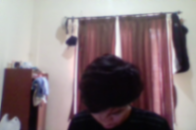

In [41]:
no_face_det = list(data_dir.glob('no face detected/*'))
PIL.Image.open(str(no_face_det[0]))

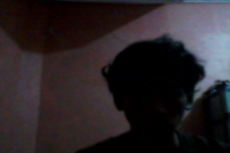

In [42]:
PIL.Image.open(str(no_face_det[1]))

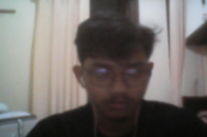

In [43]:
random = list(data_dir.glob('random/*'))
PIL.Image.open(str(random[0]))

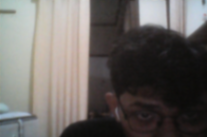

In [44]:
PIL.Image.open(str(random[1]))

# Load using keras.preprocessing

**Create a dataset**

In [45]:
batch_size = 16
img_height = 180
img_width = 180

In [46]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir, # directory
  validation_split=0.2, # 80% data untuk train
  subset="training", # untuk training
  seed=123,
  image_size=(img_height, img_width), # resize gambar
  batch_size=batch_size)

Found 33 files belonging to 2 classes.
Using 27 files for training.


In [47]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir, # directory
  validation_split=0.2, # 20% data untuk test
  subset="validation",# untuk validation atau test
  seed=123,
  image_size=(img_height, img_width), # resize gambar
  batch_size=batch_size)

Found 33 files belonging to 2 classes.
Using 6 files for validation.


In [48]:
class_names = train_ds.class_names
print(class_names)

['no face detected', 'random']


**Visualize the data**

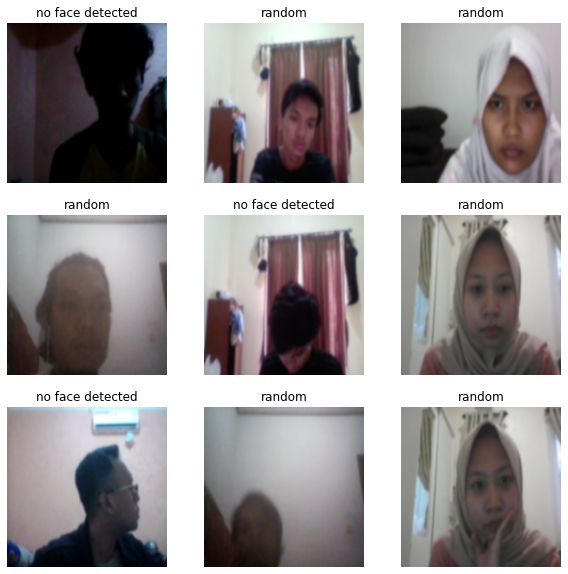

In [49]:
#Berikut adalah 9 gambar pertama dalam set data pelatihan.
#data random dan data noface detected 
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [50]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 180, 180, 3)
(16,)


**Configure the dataset for performance**

In [51]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Standardize the data**

In [52]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [53]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# perhatikan nilai pixel sekarang dalam `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.012962963 0.84186554


# Create the model

In [54]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#Model ini terdiri dari tiga blok konvolusi dengan masing-masing lapisan kolam maksimum. 
#Ada lapisan yang sepenuhnya terhubung dengan 128 unit di atasnya yang diaktifkan oleh fungsi aktivasi relu. 
#Model ini belum disetel untuk akurasi tinggi, tujuan dari tutorial ini adalah untuk menunjukkan pendekatan standar.

**Compile the model**

In [55]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Model summary**

In [56]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 64)       

**Train the model**

In [57]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
2/2 [==============================] - 2s 582ms/step - loss: 1.0839 - accuracy: 0.2886 - val_loss: 1.4492 - val_accuracy: 0.6667
Epoch 2/10
2/2 [==============================] - 1s 554ms/step - loss: 0.9653 - accuracy: 0.7116 - val_loss: 0.6502 - val_accuracy: 0.8333
Epoch 3/10
2/2 [==============================] - 1s 432ms/step - loss: 0.6231 - accuracy: 0.6659 - val_loss: 0.5854 - val_accuracy: 0.8333
Epoch 4/10
2/2 [==============================] - 1s 553ms/step - loss: 0.5246 - accuracy: 0.8956 - val_loss: 0.5104 - val_accuracy: 0.8333
Epoch 5/10
2/2 [==============================] - 1s 447ms/step - loss: 0.4379 - accuracy: 0.8596 - val_loss: 0.5084 - val_accuracy: 0.8333
Epoch 6/10
2/2 [==============================] - 1s 639ms/step - loss: 0.3965 - accuracy: 0.8956 - val_loss: 0.4937 - val_accuracy: 0.8333
Epoch 7/10
2/2 [==============================] - 1s 409ms/step - loss: 0.3614 - accuracy: 0.8843 - val_loss: 0.4776 - val_accuracy: 0.8333
Epoch 8/10
2/2 [====

**Visualize training results**

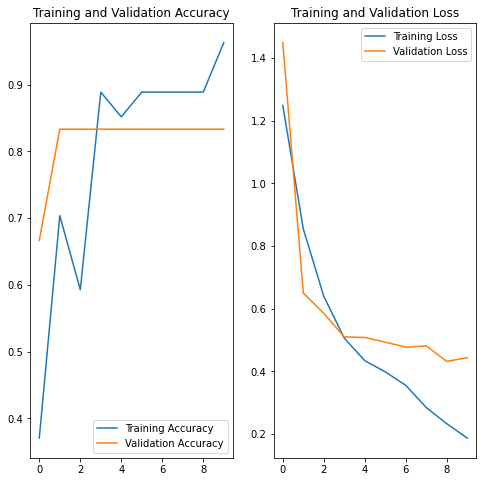

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Data augmentation**

In [59]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

#Proses ini membantu memaparkan model ke berbagai aspek data pelatihan sambil memperlambat overfitting.

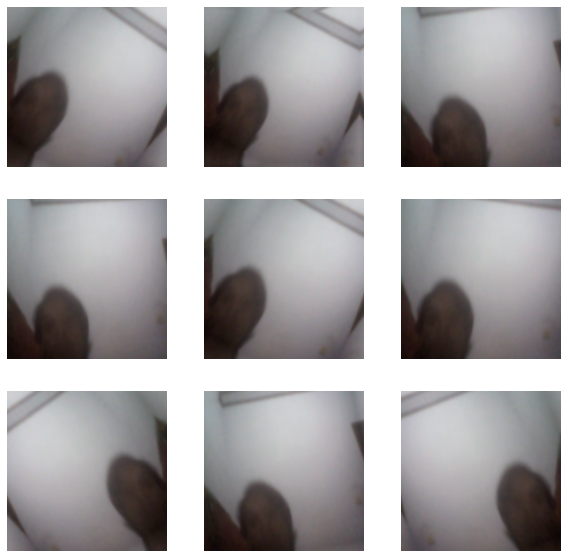

In [60]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

**Dropout**

In [61]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

**Compile and train the model**

In [62]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [63]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)       

In [64]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
2/2 [==============================] - 2s 762ms/step - loss: 1.0087 - accuracy: 0.6566 - val_loss: 0.7307 - val_accuracy: 0.6667
Epoch 2/15
2/2 [==============================] - 1s 494ms/step - loss: 0.7021 - accuracy: 0.5748 - val_loss: 0.6033 - val_accuracy: 0.8333
Epoch 3/15
2/2 [==============================] - 1s 687ms/step - loss: 0.5977 - accuracy: 0.7438 - val_loss: 0.5394 - val_accuracy: 0.6667
Epoch 4/15
2/2 [==============================] - 1s 635ms/step - loss: 0.5287 - accuracy: 0.7116 - val_loss: 0.5536 - val_accuracy: 0.6667
Epoch 5/15
2/2 [==============================] - 1s 676ms/step - loss: 0.4977 - accuracy: 0.7116 - val_loss: 0.5161 - val_accuracy: 0.8333
Epoch 6/15
2/2 [==============================] - 1s 510ms/step - loss: 0.4807 - accuracy: 0.7932 - val_loss: 0.5188 - val_accuracy: 0.8333
Epoch 7/15
2/2 [==============================] - 1s 664ms/step - loss: 0.4476 - accuracy: 0.8956 - val_loss: 0.5261 - val_accuracy: 0.8333
Epoch 8/15
2/2 [====

**Visualize training results**

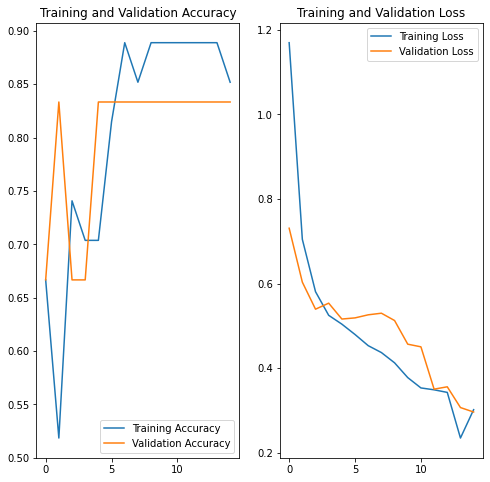

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Predict on new data**

In [66]:
import pathlib
path = "drive/My Drive/ML_CNN/random/xjRo1fJySy.png"
data_dir = pathlib.Path(path)

img = keras.preprocessing.image.load_img(
    data_dir, target_size=(img_height, img_width)
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to random with a 97.59 percent confidence.
